**Nama: Muhammad Al Fikri**  
**Asal Instansi: STT Terpadu Nurul Fikri**  
**Grup SIB: M04**

# **Recommendation System - Merekomendasikan Judul Film Berdasarkan Genrenya**

## **Deskripsi Proyek**

Pada proyek kali ini sebuah perusahaan yang bergerak di industri perfilman ingin meningkatkan traffic platform film streaming mereka, oleh karena itu perusahaan akan mencoba menerapkan pendekatan Machine Learning untuk merekomendasi film-film yang mereka sediakan berdasarkan genre filmnya.

## **1. Import Library yang Dibutuhkan**

In [95]:
# Install public API Kaggle
!pip install -q kaggle

In [96]:
# Install library untuk proses data loading dan visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

## **2. Data Understanding**

Data Understanding merupakan proses memahami informasi dalam data dan menentukan kualitas dari data tersebut.

### **2.1 Data Loading**

Data Loading merupakan tahap untuk memuat dataset yang akan digunakan agar dataset lebih mudah dipahami.             


*Dataset yang digunakan pada proyek ini:*  
https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset

In [97]:
# Membuat direktori baru bernama kaggle 
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke direktori kaggle
!mv kaggle.json ~/.kaggle/kaggle.json

# Mengubah permission berkas
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d gargmanas/movierecommenderdataset

# Ekstrak berkas zip
!unzip /content/movierecommenderdataset.zip

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 36.8MB/s]
Archive:  /content/movierecommenderdataset.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [98]:
# Melihat isi dataset movies.csv
movies = pd.read_csv('/content/movies.csv')
values = ['Comedy','Action','Adventure','Documentary','Horror','Crime','Drama','Romance','Thriller','Mystery', 'Animation', 'Fantasy']
movies = movies[movies.genres.isin(values) == True]

movies

,movieId,title,genres
4,5,Father of the Bride Part II (1995),Comedy
8,9,Sudden Death (1995),Action
13,14,Nixon (1995),Drama
17,18,Four Rooms (1995),Comedy
18,19,Ace Ventura: When Nature Calls (1995),Comedy
...,...,...,...
9730,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary
9735,193573,Love Live! The School Idol Movie (2015),Animation
9736,193579,Jon Stewart Has Left the Building (2015),Documentary
9739,193585,Flint (2017),Drama


In [99]:
# Melihat isi dataset ratings.csv
rating = pd.read_csv('/content/ratings.csv')
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### **2.2 Exploratory Data Analysis (EDA)**

Exploratory data analysis merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data

#### **2.2.1 EDA - Deskripsi Variabel**

In [100]:
# Melihat informasi pada dataset movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 4 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  2731 non-null   int64 
 1   title    2731 non-null   object
 2   genres   2731 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.3+ KB


In [101]:
# Melihat informasi pada dataset rating
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


#### **2.2.2 EDA - Univariate Analysis**

##### **- Movies**




In [102]:
# Melihat jumlah film dan jumlah genre yang ada beserta nama genrenya
print('Jumlah Film: ', len(movies.movieId.unique()))
print('Jumlah genre: ', len(movies.genres.unique()))
print('Genre: ', movies.genres.unique())

Jumlah Film:  2731
Jumlah genre:  12
Genre:  ['Comedy' 'Action' 'Drama' 'Documentary' 'Thriller' 'Horror' 'Romance'
 'Adventure' 'Crime' 'Mystery' 'Fantasy' 'Animation']


             jumlah film  persentase
Drama               1053        38.6
Comedy               946        34.6
Documentary          339        12.4
Horror               167         6.1
Thriller              84         3.1
Action                60         2.2
Animation             30         1.1
Romance               21         0.8
Adventure             12         0.4
Crime                 12         0.4
Fantasy                4         0.1
Mystery                3         0.1


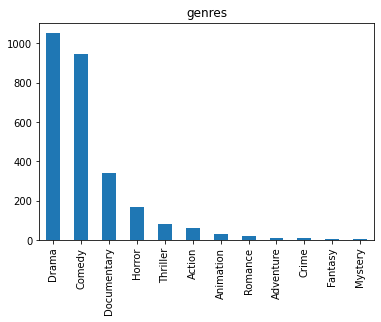

In [103]:
# Visualisasi fitur 'genres' untuk melihat pembagian isi datasetnya
categorical_features = ['genres']
feature = categorical_features[0]
count = movies[feature].value_counts()
percent = 100*movies[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah film':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature);

##### **- Rating**


In [104]:
# Melihat jumlah userID dan jumlah data rating
print('Jumlah userID: ', len(rating.userId.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah userID:  610
Jumlah data rating:  100836


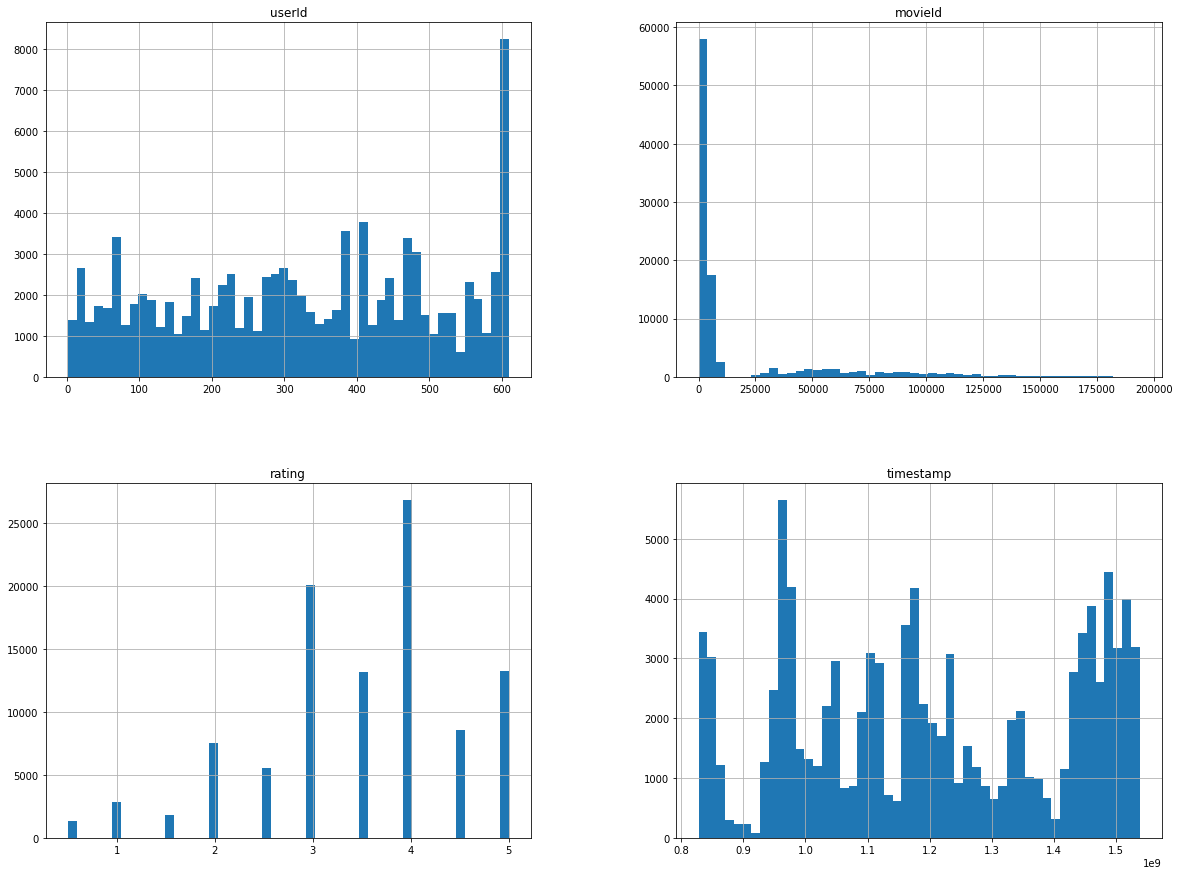

In [105]:
# visualisasi fitur numerik yang ada di dataset rating 
rating.hist(bins=50, figsize=(20,15))
plt.show()

## **3. Data Preparation**

Data Preparation merupakan tahap untuk mempersiapkan data sebelum masuk ke tahap pembuatan model Machine Learning.

### **3.1 Menggabungkan Dataset dan Menangani Missing Value**

In [106]:
# Menggabungkan dataset movies dan rating
all_movies = pd.merge(movies, rating, on='movieId', how='left')
all_movies

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,8.455539e+08
1,5,Father of the Bride Part II (1995),Comedy,31.0,3.0,8.504666e+08
2,5,Father of the Bride Part II (1995),Comedy,43.0,5.0,8.489943e+08
3,5,Father of the Bride Part II (1995),Comedy,45.0,3.0,9.596251e+08
4,5,Father of the Bride Part II (1995),Comedy,58.0,4.0,8.477192e+08
...,...,...,...,...,...,...
16012,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary,338.0,1.0,1.530148e+09
16013,193573,Love Live! The School Idol Movie (2015),Animation,184.0,4.0,1.537100e+09
16014,193579,Jon Stewart Has Left the Building (2015),Documentary,184.0,3.5,1.537107e+09
16015,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09


In [107]:
# Melihat data yang kosong
all_movies.isnull().sum()

movieId      0
title        0
genres       0
userId       6
rating       6
timestamp    6
dtype: int64

In [108]:
# Membuang data yang kosong
all_movies_clean = all_movies.dropna()
all_movies_clean

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,8.455539e+08
1,5,Father of the Bride Part II (1995),Comedy,31.0,3.0,8.504666e+08
2,5,Father of the Bride Part II (1995),Comedy,43.0,5.0,8.489943e+08
3,5,Father of the Bride Part II (1995),Comedy,45.0,3.0,9.596251e+08
4,5,Father of the Bride Part II (1995),Comedy,58.0,4.0,8.477192e+08
...,...,...,...,...,...,...
16012,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary,338.0,1.0,1.530148e+09
16013,193573,Love Live! The School Idol Movie (2015),Animation,184.0,4.0,1.537100e+09
16014,193579,Jon Stewart Has Left the Building (2015),Documentary,184.0,3.5,1.537107e+09
16015,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09


In [109]:
# Menampilkan data dan mengurutkannya berdasarkan movieId
fix_movies = all_movies_clean.sort_values('movieId', ascending=True)
fix_movies

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,8.455539e+08
27,5,Father of the Bride Part II (1995),Comedy,353.0,3.0,8.319399e+08
28,5,Father of the Bride Part II (1995),Comedy,389.0,4.0,8.579342e+08
29,5,Father of the Bride Part II (1995),Comedy,402.0,3.0,8.495981e+08
30,5,Father of the Bride Part II (1995),Comedy,414.0,2.0,9.614376e+08
...,...,...,...,...,...,...
16012,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary,338.0,1.0,1.530148e+09
16013,193573,Love Live! The School Idol Movie (2015),Animation,184.0,4.0,1.537100e+09
16014,193579,Jon Stewart Has Left the Building (2015),Documentary,184.0,3.5,1.537107e+09
16015,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09


In [110]:
# Melihat berapa jumlah film dalam fix_movies
len(fix_movies.movieId.unique())

2725

In [111]:
# Melihat genre movie setelah data dirapihkan
print('Genre: ', fix_movies.genres.unique())

Genre:  ['Comedy' 'Action' 'Drama' 'Documentary' 'Thriller' 'Horror' 'Romance'
 'Adventure' 'Crime' 'Mystery' 'Fantasy' 'Animation']


### **3.2 Menghapus Data Duplikat**

In [112]:
# Menghapus data duplikat pada variabel preparation
preparation = fix_movies.drop_duplicates('movieId')
preparation

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,8.455539e+08
59,9,Sudden Death (1995),Action,428.0,2.0,1.111525e+09
75,14,Nixon (1995),Drama,437.0,3.0,8.597211e+08
95,18,Four Rooms (1995),Comedy,380.0,4.0,1.494279e+09
167,19,Ace Ventura: When Nature Calls (1995),Comedy,477.0,3.0,1.200940e+09
...,...,...,...,...,...,...
16012,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary,338.0,1.0,1.530148e+09
16013,193573,Love Live! The School Idol Movie (2015),Animation,184.0,4.0,1.537100e+09
16014,193579,Jon Stewart Has Left the Building (2015),Documentary,184.0,3.5,1.537107e+09
16015,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09


### **3.3 Mengonversi Data Series Menjadi Bentuk List**

In [113]:
# Mengonversi data series ‘movieId’ menjadi bentuk list
movie_id = preparation['movieId'].tolist()
 
# Mengonversi data series ‘title’ menjadi bentuk list
movie_title = preparation['title'].tolist()
 
# Mengonversi data series ‘genres’ menjadi bentuk list
movie_genre = preparation['genres'].tolist()
 
print(len(movie_id))
print(len(movie_title))
print(len(movie_genre))

2725
2725
2725


In [114]:
# Membuat dictionary data 
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_title': movie_title,
    'genre': movie_genre
})
movie_new

,id,movie_title,genre
0,5,Father of the Bride Part II (1995),Comedy
1,9,Sudden Death (1995),Action
2,14,Nixon (1995),Drama
3,18,Four Rooms (1995),Comedy
4,19,Ace Ventura: When Nature Calls (1995),Comedy
...,...,...,...
2720,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary
2721,193573,Love Live! The School Idol Movie (2015),Animation
2722,193579,Jon Stewart Has Left the Building (2015),Documentary
2723,193585,Flint (2017),Drama


In [115]:
# Melihat 5 sampel movie
data = movie_new
data.sample(5)

,id,movie_title,genre
1639,27769,Down to the Bone (2004),Drama
2592,165075,London Town (2016),Drama
2195,100556,"Act of Killing, The (2012)",Documentary
1625,27140,Candyman 3: Day of the Dead (1999),Horror
275,1238,Local Hero (1983),Comedy


## **4. Model Development - Content Based Filtering**

Ide dari sistem rekomendasi berbasis konten (content-based filtering) adalah merekomendasikan item yang mirip dengan item yang disukai pengguna di masa lalu.

### **4.1 TF-IDF Vectorizer**

In [116]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tf.fit(data['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'thriller']

In [117]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(2725, 12)

In [118]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [119]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan movie title
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.movie_title
).sample(12, axis=1).sample(10, axis=0)

,thriller,drama,action,animation,documentary,crime,fantasy,horror,mystery,adventure,comedy,romance
movie_title,,,,,,,,,,,,
The Void (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Blue Jasmine (2013),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
By the Law (1926),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Madhouse (1990),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"House of Mirth, The (2000)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Eye of the Beholder (1999),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Birdcage, The (1996)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Caligula (1979),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Campfire Tales (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### **4.2 Cosine Similarity**

In [120]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [121]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa movie title
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movie_title'], columns=data['movie_title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap movie title
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (2725, 2725)


movie_title,Death of a Salesman (1985),"Masque of the Red Death, The (1964)",Game of Death (1978),Aces: Iron Eagle III (1992),Moonlight
movie_title,,,,,
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0
Halloween 5: The Revenge of Michael Myers (1989),0.0,1.0,0.0,0.0,0.0
Gentleman's Agreement (1947),1.0,0.0,0.0,0.0,1.0
Baby Geniuses (1999),0.0,0.0,0.0,0.0,0.0
Hearts of Darkness: A Filmmakers Apocalypse (1991),0.0,0.0,0.0,0.0,0.0
Amos & Andrew (1993),0.0,0.0,0.0,0.0,0.0
Employee of the Month (2006),0.0,0.0,0.0,0.0,0.0
Blackadder Back & Forth (1999),0.0,0.0,0.0,0.0,0.0
Like Stars on Earth (Taare Zameen Par) (2007),1.0,0.0,0.0,0.0,1.0


### **4.3 Membuat Fungsi movie_recommendation()**

In [122]:
def movie_recommendations(movie_title, similarity_data=cosine_sim_df, items=data[['movie_title', 'genre']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,movie_title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Membuang movie_title agar nama film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(movie_title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

### **4.4. Result**

In [123]:
# Melihat genre film yang akan diuji
movie_title = 'Piper (2016)'
data[data.movie_title.eq(movie_title)]

,id,movie_title,genre
2565,160718,Piper (2016),Animation


In [124]:
# Menampilkan hasil rekomendasi judul film berdasarkan genre
movie_title = 'Piper (2016)'
movie_recommendations = movie_recommendations(movie_title)
movie_recommendations

,movie_title,genre
0,A Plasticine Crow (1981),Animation
1,The Red Turtle (2016),Animation
2,The Monkey King (1964),Animation
3,Winter in Prostokvashino (1984),Animation
4,Vacations in Prostokvashino (1980),Animation
5,Garfield's Pet Force (2009),Animation
6,Nasu: Summer in Andalusia (2003),Animation
7,Three from Prostokvashino (1978),Animation
8,Investigation Held by Kolobki (1986),Animation
9,"Fireworks, Should We See It from the Side or t...",Animation


## **5. Evaluation**

Metrik yang cocok dipakai untuk kasus content based filtering adalah ***Precision***, yang dapat dirumuskan sebagai berikut: 



![img](https://dicoding-web-img.sgp1.cdn.digitaloceanspaces.com/original/academy/dos:819311f78d87da1e0fd8660171fa58e620211012160253.png)


Berdasarkan hasil di atas dapat disimpulkan bahwa dari 10 judul film yang direkomendasikan, ada 10 item yang relevan, oleh karena itu ***Precision*** dari model tersebut adalah 10/10 atau 100%